# Purpose of this code:
- Update labelmap, Train, Update Checkpoint and finally Detect in a real-time environement.


In [1]:
# Setup Paths
# Just creating shortcuts for the known paths that shall be used
WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'

In [2]:
# Create Label Map for specific categories
labels = [
    {'name':'right', 'id':1}, 
    {'name':'left', 'id':2},
    {'name':'up', 'id':3},
    {'name':'down', 'id':4},
    {'name':'jump', 'id':5},
    {'name':'shoot', 'id':6}
] 
#The label map is a representation of all the diferent objetcs we got within our model

#Writing label map with specific categories
with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

- After running this Input we should get this new archive:

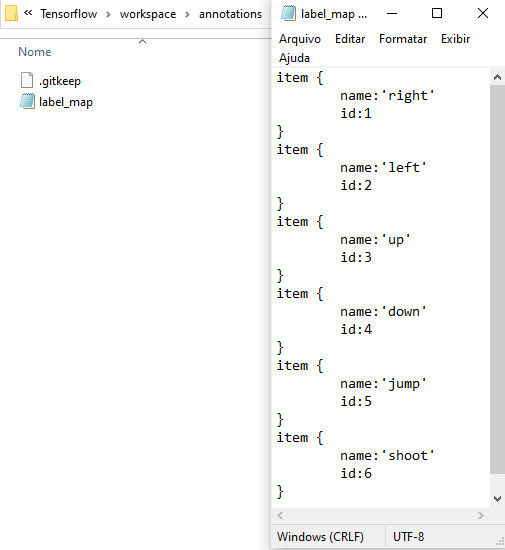

In [5]:
# Generate TF records by running the code from the official tensorflow object detection tutorial.
#Tf records for train:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
#Tf records for test:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record


Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


- After running this Input we should get these 2 news archives:
    
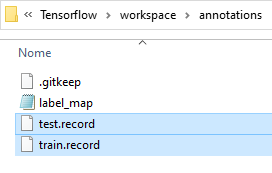

Now we have the Labels updated.

In [6]:
# Download TF Models - Pretrained Models from Tensorflow Model Zoo
# Cloning one official TensorFlow object detection library
!cd Tensorflow && git clone https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


- After running this Input we should get this new folder:

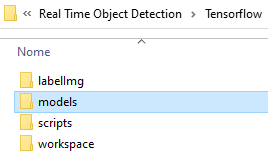

In [3]:
# Copy Model Config to Training Folder
#Setting up configuration Path
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 

In [9]:
#Creating the folder and copying up a onfiguration to it
!mkdir {'Tensorflow\workspace\models\\'+CUSTOM_MODEL_NAME} #Creating the folder
!cp {PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}
#Copying up a onfiguration to it

'cp' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


- After running these 2 Inputs we should get this new config:

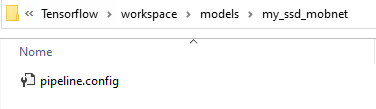

In [ ]:
# Update Config For Transfer Learning

#importing useful dependecies:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [5]:
# Grabing configuration path
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [ ]:
#Getting configuration code
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [13]:
#Plotting configuration code
config

{'model': ssd {
   num_classes: 6
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

- Since it is a prebuilt configuration code, there are some exchanges which will be done in the following code lines:

In [14]:
#Reading
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [15]:
# Preconfigured cell to make the necessary exchange in the config code:
pipeline_config.model.ssd.num_classes = 6 #number of classes, for us they are "up", "down", "right", "left", "shoot" and "jump"

pipeline_config.train_config.batch_size = 4 # how much data is processed within each EPOC

pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
# Where the model will start training from, possibilitating the use of Transfer Learning to be able to train the model faster

pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
#Changing fine_tune_checkpoint to detection type

pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
#specifying tf train records path

pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']
#specifying tf test records path

In [16]:
#Writing
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   
    
#Now we will have the configuration updated for this projects purpose!

In [17]:
#Train the model
#To train the model, the following python scrip was writen:
print("""python {}/research/object_detection/model_main.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=10000""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))
#With some superficial research online,
#a 10000 steps aproach is what looks like to get the best results for this kind of model

#With that, we can just copy and paste the printed script into our command prompt, inside "Real Time Object Detection" folder, it will start the proccess
#of training a deep learning model. 


python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=5000


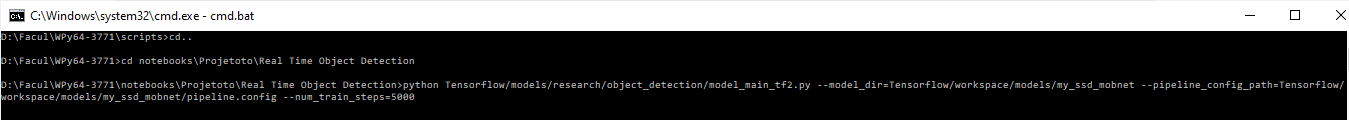

The speed of the training will depend on the hardware of the machine. For me, since my machine is not so "powerful", it took about 3 hours to train everyting.
 - That is one of the points for me not training again with more data (images) or more steps, since it took a big amount of time to finish this proccess, with the computer not being very functional in the meantime. The images bellow are proof of the time taken:
 
 
 Start of proccess:
 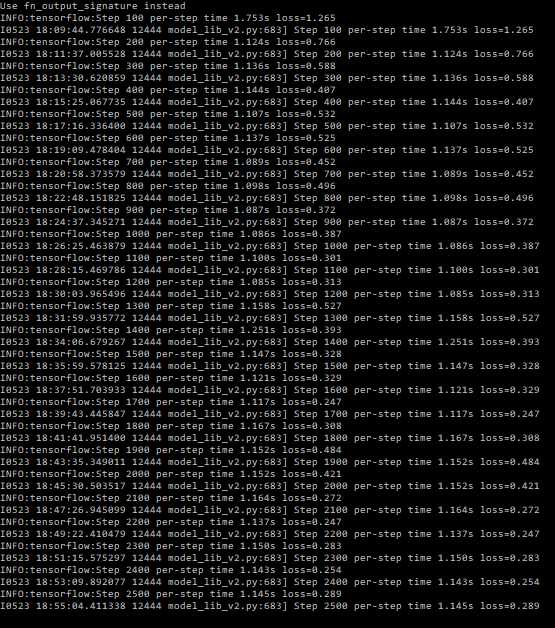
 
 End of proccess:
 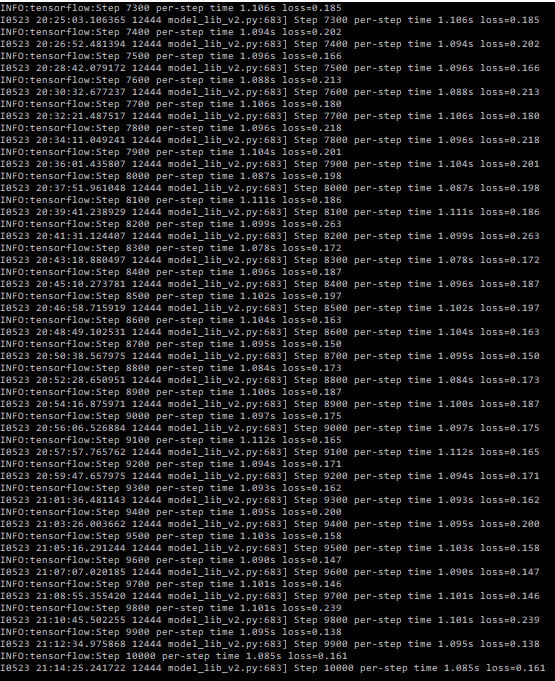
 

#### With the model finally trained it is just a matter of loading it and using it for the real time recognition via webcam!

In [6]:
# Load Train Model From Checkpoint

#importing useful dependecies:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

Inside Models folder, there will be the checkpoint for the model trainig. It is necessary to update thee restoration point with the latest checkpoint of the proccess. In my case it was checkpoint 11:

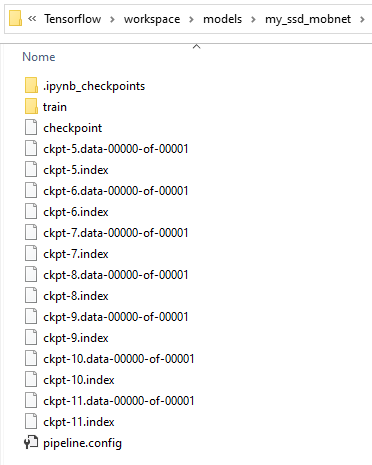

In [7]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-11')).expect_partial() # <-- Must be checked and updated!!!


In [ ]:
# Detection function
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [8]:
# Detect in Real-Time (Finally!)

#importing useful dependecies:
import cv2 
import numpy as np

In [9]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [11]:
# Setup capture
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [12]:
# Real time webcam hand detection loop

while True: 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=3, # Can be changed to the max of drawn boxes on the detection
                # Since it is a hand detection for one person only, no more them 2 boxes should be enough,
                # However, I used 3 boxes to know how was the precision of the adjacent detections.
                min_score_thresh=.1, # Thresholding, setted really low for tests.
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(1) & 0xFF == ord('q'): # Press q to leave the loop
        cap.release()
        break
        
cap.release()
cv2.destroyAllWindows()

4 tests were recorded, with diferent thresholdings and an improvement of lightning to look for an improvement of the hand signs detection:

https://drive.google.com/drive/folders/1bXeCT-oQvp_qpwtjxE_baFJcYEqWR1Wd?usp=sharing

###### Check videos on drive file, -Image Treatment project/Extra/Videos:
- Thresholdin50pc.mkv
- Thresholdin30pc.mkv
- Thresholdin10pc.mkv
- Better Ilumination th 10pc.mkv

In [ ]:
# Video detection with thresholdings at 50%

# cap = cv2.VideoCapture('Thresholdin50pc.mkv')
# while cap.isOpened():
#    ret,frame = cap.read()

#     cv2.imshow('Th 50',frame)

#     if cv2.waitKey(2) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()

In [ ]:
# Video capture with thresholdings at 30%

# cap = cv2.VideoCapture('Thresholdin30pc.mkv')
# while cap.isOpened():
#     ret,frame = cap.read()

#     cv2.imshow('Th 30',frame)

#     if cv2.waitKey(2) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()

In [ ]:
# Video capture with thresholdings at 10%

# cap = cv2.VideoCapture('Thresholdin10pc.mkv')
# while cap.isOpened():
#     ret,frame = cap.read()

#     cv2.imshow('Th 30',frame)

#     if cv2.waitKey(2) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()

In [ ]:
# Video capture with thresholdings at 10% and better lightning

# cap = cv2.VideoCapture('Better Ilumination th 10pc.mkv')
# while cap.isOpened():
#     ret,frame = cap.read()

#     cv2.imshow('Th 30',frame)

#     if cv2.waitKey(2) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()

# Conclusion 1:

Learning on every step of the way, this project helped a lot in fixing the theories previously taught. Getting from the basics of the simple acquisition of data to the advanced part of training and using a model to detect in a real time video capture was a great experience. There are plenty of points which could be adapted or improved:
Since the data acquisition with the use of a clean background, the capture solely of the hands image, more disparate hand positions, better camera resolution; to the modeling step with the acquisintion and trainig of more data (15 for each category really isn't enougth), more steps in training, better computer hardware configuration to make the whole proccess more quickly and viable, and many others. 

In the end, even tough the recognition of hand signs does not have an satisfatory precision, it is possible to confirm that there is some regonition, of course it still is not enought for the precise control of a computer game. So from this point on, by finnishing "Step 3", the project moves to "Step 4" with a prebuilt model of hand sign specifcly in the directory of "Hand Gestures Controling"

Learning at each step of the way, this project helped a lot in fixing the theories previously taught. Moving from the basics of simple data acquisition to the advanced part of training and using a model to detect in a real-time video capture was a great experience. There are many points that can be adapted or improved but couldn't be done mainly due to lack of necessary material or time:
Since the acquisition of data Step using a clean background, capturing only the image of the hands, more disparate hand positions, better resolution of the camera; to the modeling Step with acquisition and training of more data, more training steps, better configuration of the computer hardware to make the whole process faster and more feasible, updates in the coding for better implementation, and many others.

In the end, even if the recognition of hand signals is not satisfactorily accurate, it is possible to verify that there is some recognition, of course it is still far away from one necessary for the precise control of a computer game. Therefore, from this point and on,after finnishing "Step 3", the project moves to the lest part in "Step 4", with a pre-built model of hand signals, specifically in the "Hand Gesture Control" directory:

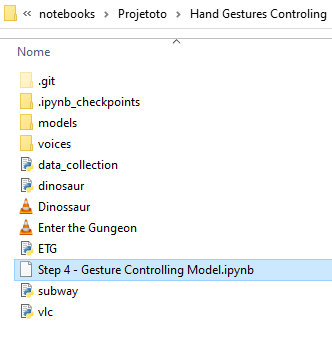